# Part-Of-Speech (POS) tagging using RNN (LSTM)

The goal of this notebook is to train a LSTM based model to tag classify words of sentences into categories of POS (Noun, Verb, Adjective, Determinant etc...)

## Let's first load and preprocess our data

In [1]:
import nltk
from nltk.corpus import brown

In [2]:
# nltk.download('brown')
# nltk.download('universal_tagset')

[nltk_data] Downloading package brown to /Users/clement/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/clement/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [3]:
corpus = brown.tagged_sents(tagset='universal')

In [4]:
corpus

[[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')], [('The', 'DET'), ('jury', 'NOUN'), ('further', 'ADV'), ('said', 'VERB'), ('in', 'ADP'), ('term-end', 'NOUN'), ('presentments', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('City', 'NOUN'), ('Executive', 'ADJ'), ('Committee', 'NOUN'), (',', '.'), ('which', 'DET'), ('had', 'VERB'), ('over-all', 'ADJ'), ('charge', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('election', 'NOUN'), (',', '.'), ('``', '.'), ('deserves', 'VERB'), ('the', 'DET'), ('praise', 'NOUN'), ('and', 'CONJ'), ('thanks', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('City

In [5]:
inputs = []
targets = []

for sentence_tag_pairs in corpus:
  tokens = []
  target = []
  for token, tag in sentence_tag_pairs:
    tokens.append(token)
    target.append(tag)
  inputs.append(tokens)
  targets.append(target)

In [9]:
print(inputs[0])
print(targets[0])

['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.']
['DET', 'NOUN', 'NOUN', 'ADJ', 'NOUN', 'VERB', 'NOUN', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADJ', 'NOUN', 'NOUN', 'VERB', '.', 'DET', 'NOUN', '.', 'ADP', 'DET', 'NOUN', 'VERB', 'NOUN', '.']


## Now let's create our training and test dataset

In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, Bidirectional
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [11]:
train_inputs, test_inputs, train_targets, test_targets = train_test_split(
    inputs,
    targets,
    test_size=0.3,
)

#### Tokenize dataset

Here we want to keep capitalized words because Nouns and Verbs could be similar when lowercase (Bill and to bill).
We also need to add an 'UNK' token to map all unknown word to.

In [12]:
# Convert sentences to sequences

MAX_VOCAB_SIZE = None

# capitalization might be useful - test it
should_lowercase = False
word_tokenizer = Tokenizer(
    num_words=MAX_VOCAB_SIZE,
    lower=should_lowercase,
    oov_token='UNK',
)
# otherwise unknown tokens will be removed and len(input) != len(target)
# input words and target words will not be aligned!

word_tokenizer.fit_on_texts(train_inputs)
train_inputs_int = word_tokenizer.texts_to_sequences(train_inputs)
test_inputs_int = word_tokenizer.texts_to_sequences(test_inputs)

In [13]:
# get word -> integer mapping
word2idx = word_tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 47351 unique tokens.


In [14]:
def flatten(list_of_lists):
  flattened = [val for sublist in list_of_lists for val in sublist]
  return flattened

all_train_targets = set(flatten(train_targets))
all_test_targets = set(flatten(test_targets))
# Make sure that our training set and test set have the same possible target values
all_train_targets == all_test_targets

True

In [15]:
# Convert targets to sequences
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(train_targets)
train_targets_int = tag_tokenizer.texts_to_sequences(train_targets)
test_targets_int = tag_tokenizer.texts_to_sequences(test_targets)

# save for later
train_targets_int_unpadded = train_targets_int
test_targets_int_unpadded = test_targets_int

In [16]:
# before padding, find max document length
# because we don't want to truncate any inputs
# which would also truncate targets
maxlen_train = max(len(sentence) for sentence in train_inputs)
maxlen_test = max(len(sentence) for sentence in test_inputs)
T = max((maxlen_train, maxlen_test))

In [18]:
# pad sequences so that we get a N x T matrix
train_inputs_int = pad_sequences(train_inputs_int, maxlen=T)
print('Shape of data train tensor:', train_inputs_int.shape)

test_inputs_int = pad_sequences(test_inputs_int, maxlen=T)
print('Shape of data test tensor:', test_inputs_int.shape)

train_targets_int = pad_sequences(train_targets_int, maxlen=T)
print('Shape of train targets tensor:', train_targets_int.shape)

test_targets_int = pad_sequences(test_targets_int, maxlen=T)
print('Shape of test targets tensor:', test_targets_int.shape)


Shape of data train tensor: (40138, 180)
Shape of data test tensor: (17202, 180)
Shape of train targets tensor: (40138, 180)
Shape of test targets tensor: (17202, 180)


In [19]:
# number of classes
K = len(tag_tokenizer.word_index) + 1
K

13

## Let's create our model

In [21]:
# We get to choose embedding dimensionality
D = 32

model = tf.keras.Sequential([
    Input(shape=(T,)),
    Embedding(V + 1, D, mask_zero=True),
    Bidirectional(LSTM(32, return_sequences=True)),
    Dense(K)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 180, 32)           1515264   
                                                                 
 bidirectional (Bidirectiona  (None, 180, 64)          16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 180, 13)           845       
                                                                 
Total params: 1,532,749
Trainable params: 1,532,749
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Compile and fit
model.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy']
)

# NOTE: you "could" speed this up by creating a custom loss, since Tensorflow's
# implementation of mask_zero currently sucks, but it's sufficiently advanced
# to be outside the scope of this course
# In my experiments, CPU is faster than GPU in all cases, and CPU for custom
# loss is faster than CPU for mask_zero

# > 300-400s per epoch on CPU
# > 30 MINUTES per epoch on GPU
print('Training model...')
r = model.fit(
  train_inputs_int,
  train_targets_int,
  epochs=5,
  validation_data=(test_inputs_int, test_targets_int)
)

Training model...
Epoch 1/5


2023-05-19 12:18:58.242391: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1255/1255 [==============================] - 76s 58ms/step - loss: 0.4701 - accuracy: 0.8586 - val_loss: 0.1116 - val_accuracy: 0.9654
Epoch 2/5
1255/1255 [==============================] - 73s 58ms/step - loss: 0.0710 - accuracy: 0.9781 - val_loss: 0.0908 - val_accuracy: 0.9709
Epoch 3/5
1255/1255 [==============================] - 74s 59ms/step - loss: 0.0439 - accuracy: 0.9862 - val_loss: 0.0851 - val_accuracy: 0.9734
Epoch 4/5
1255/1255 [==============================] - 75s 59ms/step - loss: 0.0329 - accuracy: 0.9896 - val_loss: 0.0884 - val_accuracy: 0.9733
Epoch 5/5
1255/1255 [==============================] - 76s 60ms/step - loss: 0.0258 - accuracy: 0.9918 - val_loss: 0.0918 - val_accuracy: 0.9735


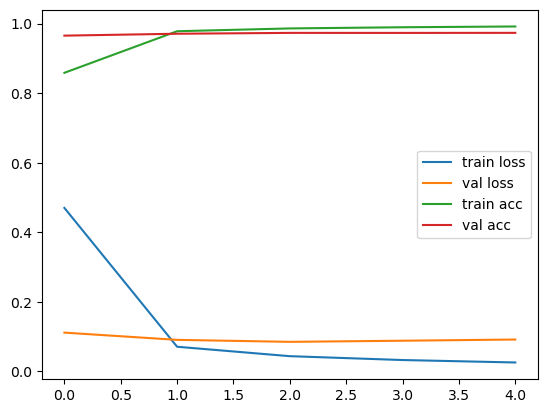

In [23]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();

### Get True model accuracy

In [24]:
# first get length of each sequence
train_lengths = []
for sentence in train_inputs:
  train_lengths.append(len(sentence))

test_lengths = []
for sentence in test_inputs:
  test_lengths.append(len(sentence))


train_probs = model.predict(train_inputs_int) # N x T x K
train_predictions = []
for probs, length in zip(train_probs, train_lengths):
  # probs is T x K
  probs_ = probs[-length:]
  preds = np.argmax(probs_, axis=1)
  train_predictions.append(preds)

# flatten
flat_train_predictions = flatten(train_predictions)
flat_train_targets = flatten(train_targets_int_unpadded)

test_probs = model.predict(test_inputs_int) # N x T x K
test_predictions = []
for probs, length in zip(test_probs, test_lengths):
  # probs is T x K
  probs_ = probs[-length:]
  preds = np.argmax(probs_, axis=1)
  test_predictions.append(preds)

# flatten
flat_test_predictions = flatten(test_predictions)
flat_test_targets = flatten(test_targets_int_unpadded)


538/538 [==============================] - 6s 10ms/step


In [25]:
from sklearn.metrics import accuracy_score, f1_score

print("Train acc:", accuracy_score(flat_train_targets, flat_train_predictions))
print("Test acc:", accuracy_score(flat_test_targets, flat_test_predictions))

print("Train f1:",
      f1_score(flat_train_targets, flat_train_predictions, average='macro'))
print("Test f1:",
      f1_score(flat_test_targets, flat_test_predictions, average='macro'))

Train acc: 0.9942057333261253
Test acc: 0.9734568825514565
Train f1: 0.9868691102909879
Test f1: 0.9341323717914558
